# Fetching Data

In [96]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sn

In [97]:
root_path = "WESAD"
zip_label = "_E4_Data.zip"
E4_label = "_E4_Data"

In [98]:
pacient_state = {
    0: "Not Defined/Transient",
    1: "Baseline",
    2: "Stress",
    3: "Amusement",
    4: "Meditation",
    5: "Error/Not Labeled",
    6: "Error/Not Labeled",
    7: "Error/Not Labeled"
}

In [99]:
num_states = 6
num_labels = 8

In [100]:
chest_signal_available = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']

In [101]:
subjects_available = os.listdir(root_path)

In [102]:
def get_input_chest_data(subjects_list):
    
    chest_df_list = []
    
    for subject in subjects_list:
        
        pkl_path = os.path.join(root_path, subject, subject + ".pkl")
        f=open(pkl_path,'rb')
        data=pickle.load(f,encoding='latin1')
        
        index_df = [i for i in range(1, len(data["label"]) + 1)]

        chest_data = {
            body_signal: data["signal"]["chest"][body_signal].reshape(len(data["signal"]["chest"][body_signal]),)
            for body_signal in chest_signal_available
        }
        chest_data["subject"] = data["subject"]
        chest_data["label_id"] = data["label"]
        chest_data["label"] = [pacient_state[i]  for i in data["label"]]

        chest_df_list.append(pd.DataFrame(chest_data, index = index_df))
        
    return chest_df_list

In [103]:
input_chest_data = get_input_chest_data(subjects_available)

# Investigating Data

In [104]:
sample_df = input_chest_data[0]

sample_df

,ECG,EMG,EDA,Temp,Resp,subject,label_id,label
1,-1.333694,-0.013687,0.716019,33.695862,0.213623,S10,0,Not Defined/Transient
2,-1.327744,-0.021927,0.714493,33.741333,0.192261,S10,0,Not Defined/Transient
3,-1.322067,-0.009018,0.715637,33.717072,0.205994,S10,0,Not Defined/Transient
4,-1.316345,-0.002380,0.714874,33.741333,0.193787,S10,0,Not Defined/Transient
5,-1.310257,0.001053,0.715256,33.747406,0.172424,S10,0,Not Defined/Transient
...,...,...,...,...,...,...,...,...
3847196,0.522949,0.017029,1.720810,35.015808,-2.032471,S10,0,Not Defined/Transient
3847197,0.526932,0.002060,1.707077,35.018921,-2.030945,S10,0,Not Defined/Transient
3847198,0.530502,0.006546,1.704407,35.020447,-2.183533,S10,0,Not Defined/Transient
3847199,0.533752,-0.001419,1.748276,34.932495,-2.003479,S10,0,Not Defined/Transient


<AxesSubplot:>

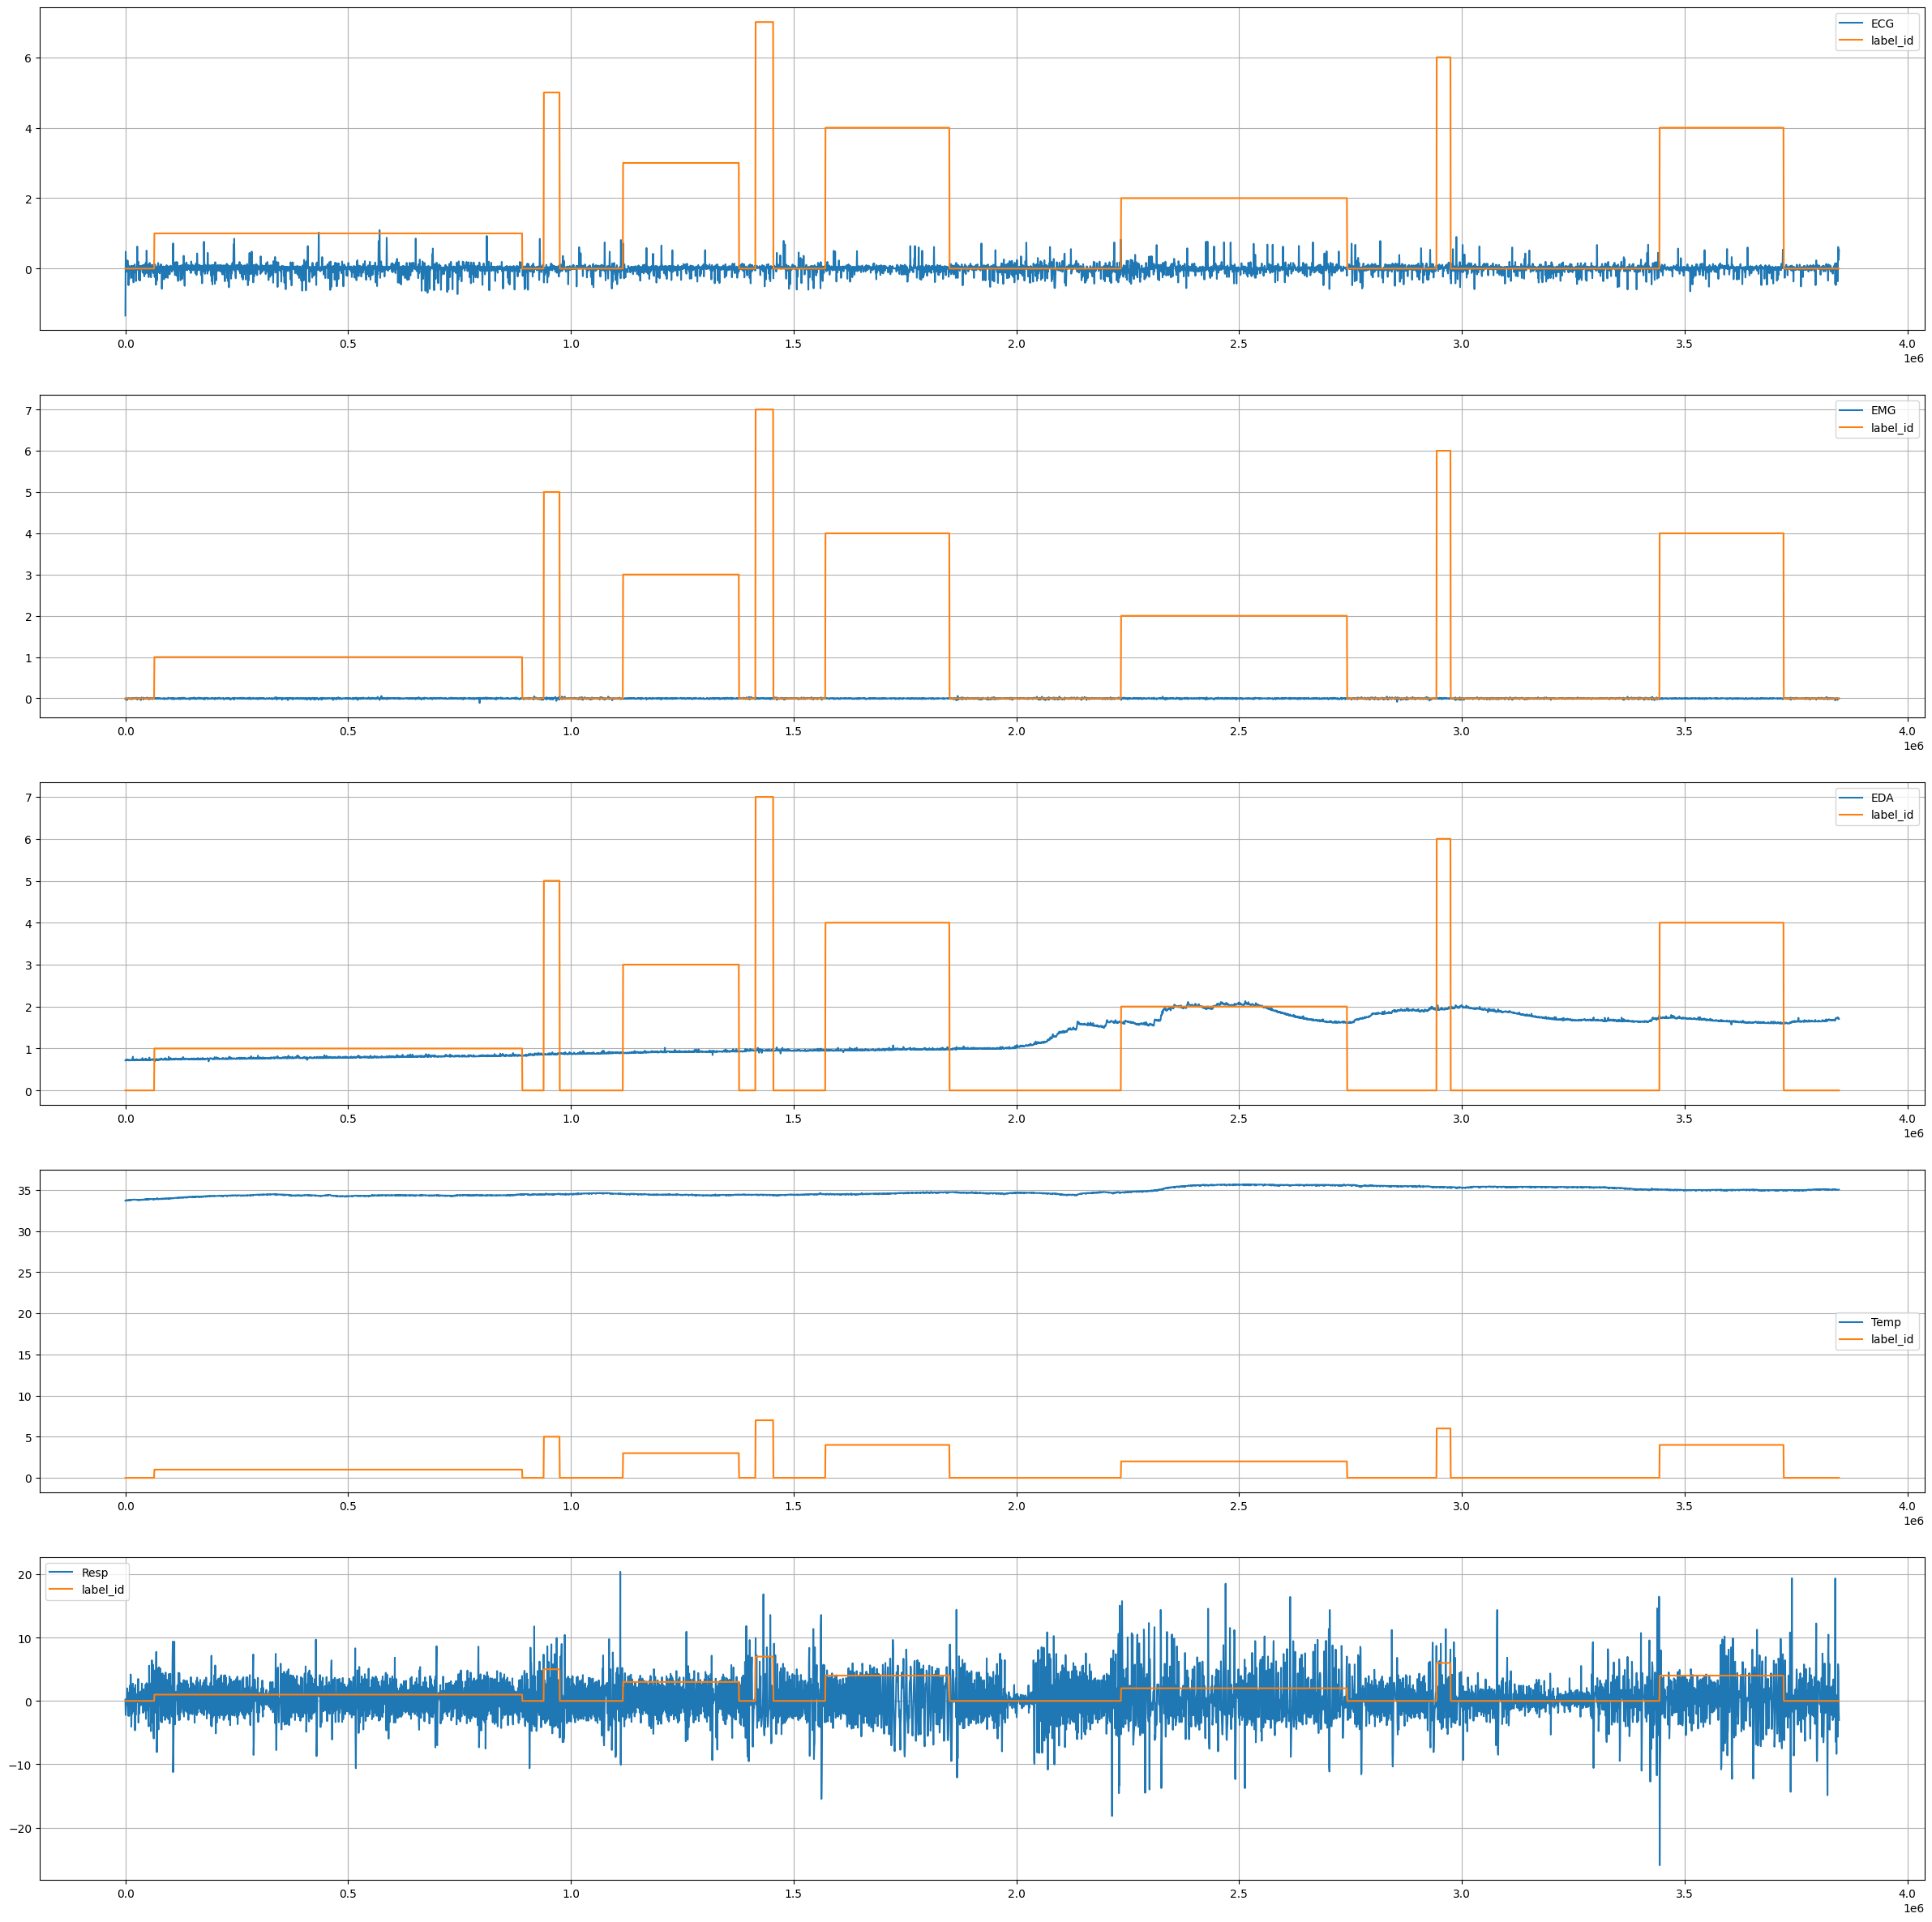

In [105]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1)

sample_df[::700].plot(figsize=(30, 30), grid=True, y=["ECG", "label_id"], ax=ax1)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["EMG", "label_id"], ax=ax2)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["EDA", "label_id"], ax=ax3)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["Temp", "label_id"], ax=ax4)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["Resp", "label_id"], ax=ax5)

In [106]:
sample_corr_df  = sample_df.corr("pearson")

sample_corr_df

,ECG,EMG,EDA,Temp,Resp,label_id
ECG,1.000000,-0.159615,-0.000054,0.000009,0.012907,0.000192
EMG,-0.159615,1.000000,-0.010648,-0.011981,0.000159,-0.003744
EDA,-0.000054,-0.010648,1.000000,0.923337,-0.001085,-0.027200
Temp,0.000009,-0.011981,0.923337,1.000000,-0.000154,-0.026514
Resp,0.012907,0.000159,-0.001085,-0.000154,1.000000,-0.002492
label_id,0.000192,-0.003744,-0.027200,-0.026514,-0.002492,1.000000


<AxesSubplot:>

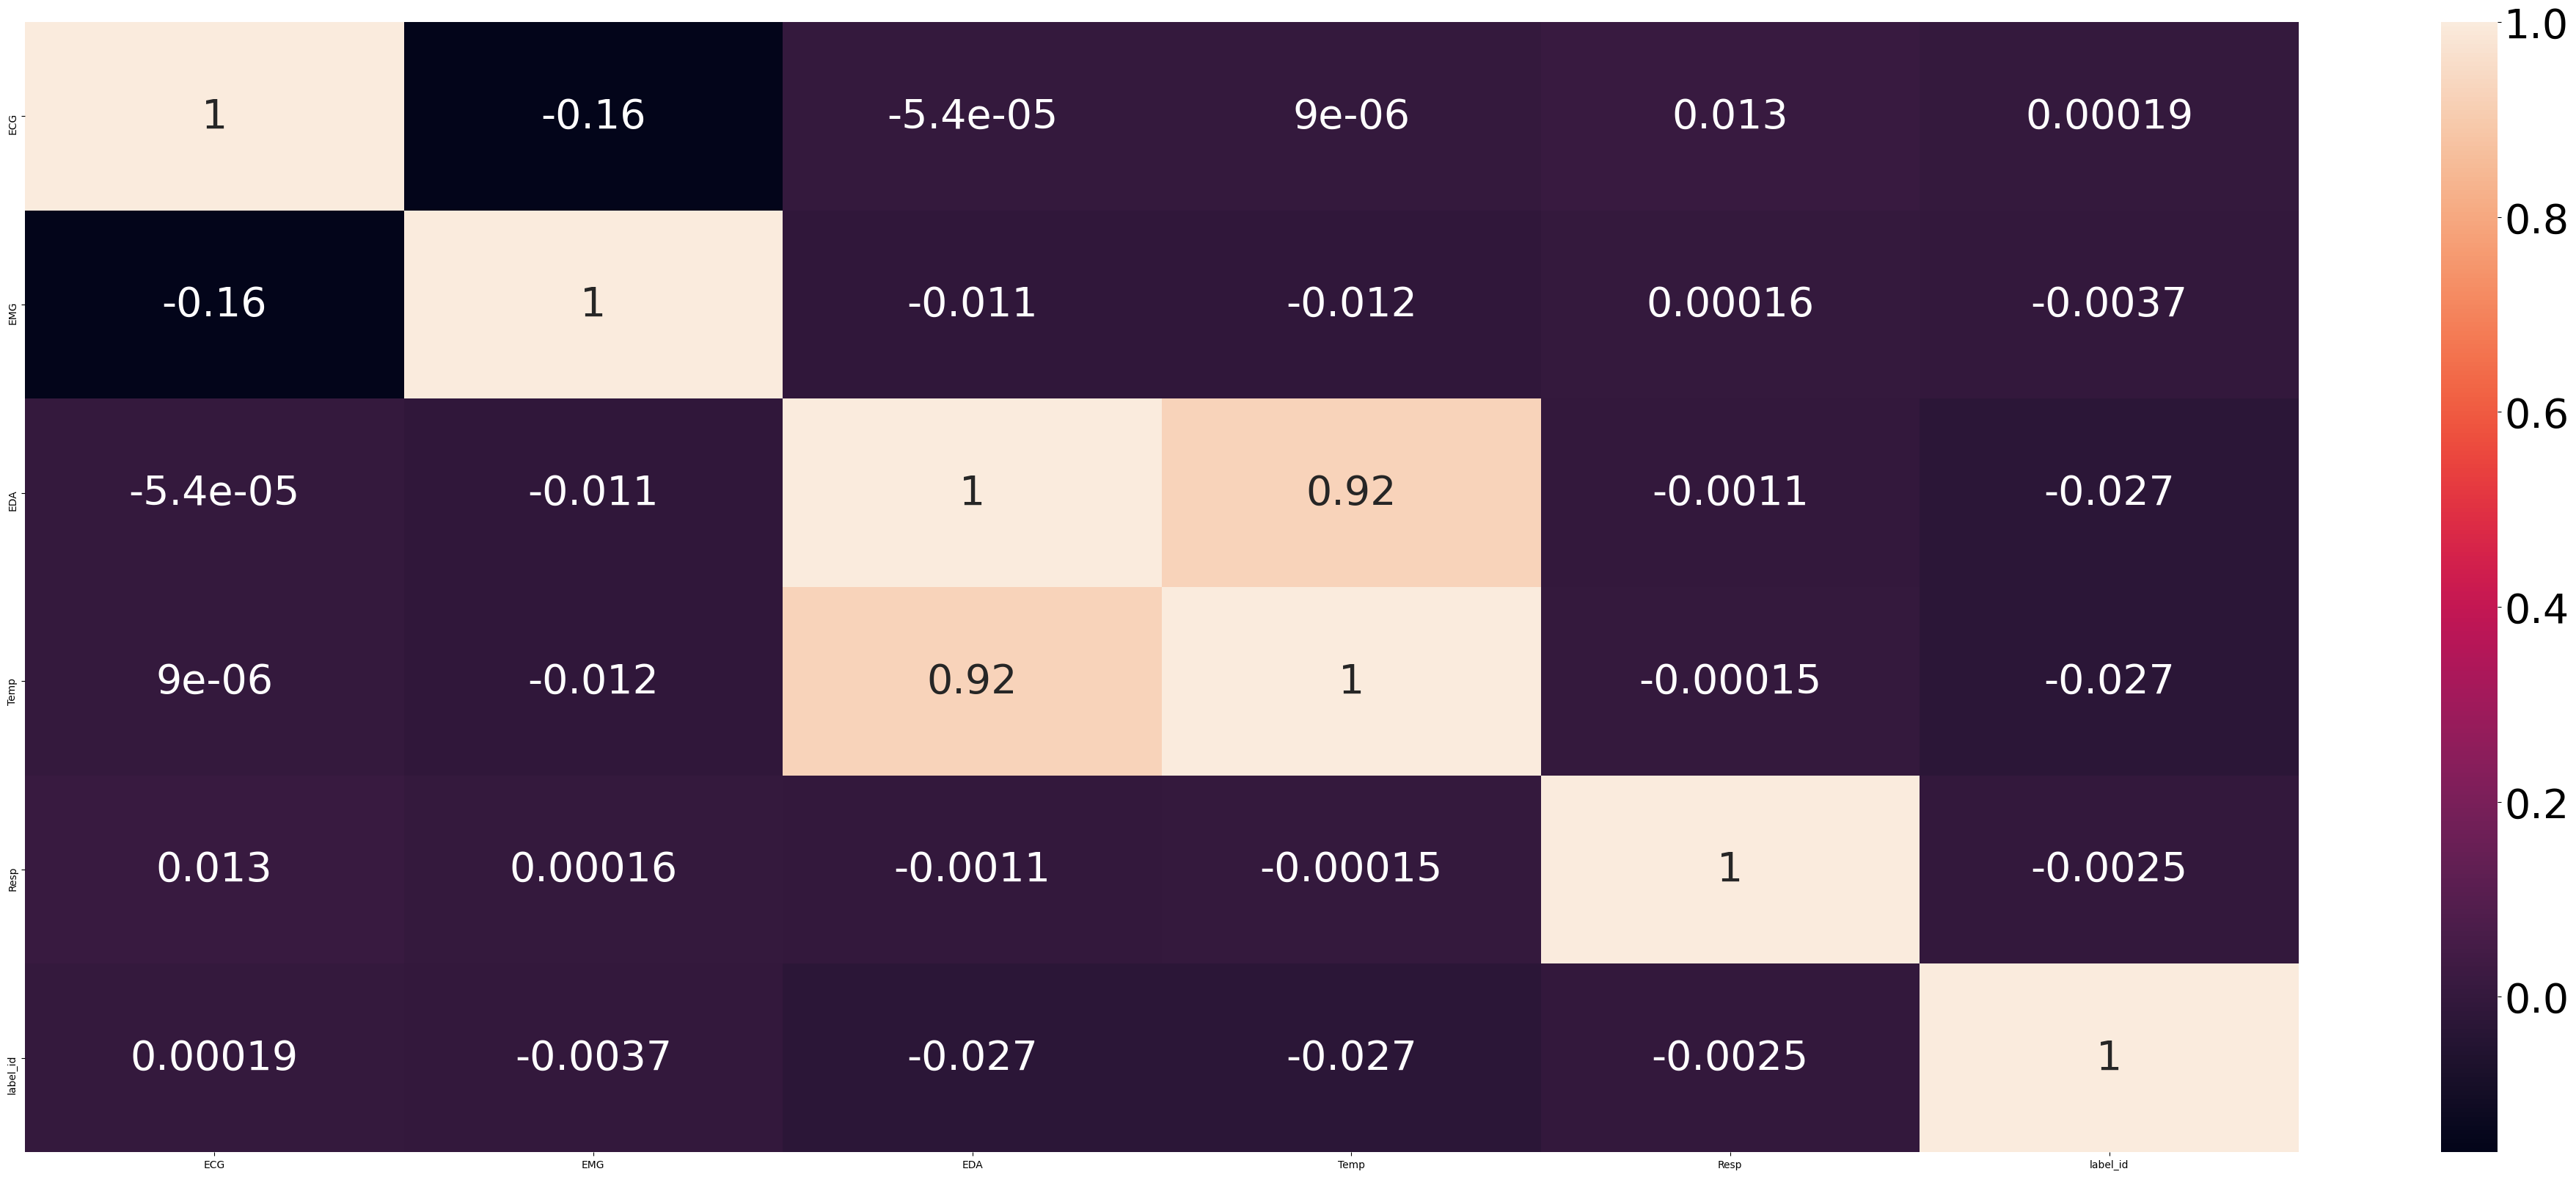

In [107]:
fig,ax_corr = plt.subplots(1, 1, figsize=(50,20))
plt.rcParams.update({'font.size': 40})

sn.heatmap(sample_corr_df, annot=True, ax=ax_corr)

# Cleaning Data

In [108]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [109]:
pacient_state_list  = [[state, pacient_state[state]] for state in pacient_state]

enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(pacient_state_list)

enc.categories_

[array([0, 1, 2, 3, 4, 5, 6, 7], dtype=object),
 array(['Amusement', 'Baseline', 'Error/Not Labeled', 'Meditation',
        'Not Defined/Transient', 'Stress'], dtype=object)]

In [110]:
win_size = 60 # represent 1 minute

def simple_rolling_z_score(x, window):
    r = x.rolling(window=window)
    m = r.mean()
    s = r.std(ddof=0)
    z = (x-m)/s
    return z

In [111]:
def rolling_z_score(df, win_size):

    copy_df = df.copy()

    for i in range(len(df) - win_size + 1):
        slicer = slice(i, win_size + i)
        mean = df[slicer].mean()
        std = df[slicer].std(ddof=0)

        copy_df[slicer] = (df[slicer] - mean) / std

    return copy_df


In [112]:
clean_chest_data = []

for data_df in input_chest_data:

    # resampling data choosing one point each 700 points

    resample_data_df = data_df[::700]

    # apllying one hot encoder

    label = resample_data_df.pop("label").to_numpy()
    label_id = resample_data_df.pop("label_id").to_numpy()

    label_list = [[label_id[i], label[i]] for i in range(len(resample_data_df))]

    target = enc.transform(label_list).toarray()

    # applying rolling score-z

    subject_label = resample_data_df.pop("subject").to_numpy()[0]

    nodmalized_data_df = rolling_z_score(
        resample_data_df,
        win_size
    )

    # tuple = (normalized_data_df, target, subject_label)

    clean_chest_data.append((nodmalized_data_df, target, subject_label))



In [113]:
sample = clean_chest_data[0]

In [114]:
sample

(              ECG       EMG       EDA      Temp      Resp
 1       -5.284552 -0.716667 -0.892131 -2.260638  0.114234
 701      2.750028 -0.565830 -0.551338 -1.773574 -1.241856
 1401     0.292426 -1.977876 -0.389471 -1.496541 -0.825565
 2101    -0.397018  0.914721  0.763412 -2.968296  0.140404
 2801     0.132320  0.832655 -0.891463 -1.087659 -0.368647
 ...           ...       ...       ...       ...       ...
 3843701 -1.993469 -0.376275  2.447488 -0.700350 -1.141627
 3844401  3.252492 -0.913643  1.161828 -0.894879  1.182826
 3845101  3.158615 -0.015673  1.939203 -1.187634  0.932095
 3845801  1.245760 -0.436376  1.729910 -0.845765 -0.293046
 3846501  2.785086 -0.005067  0.937585 -0.359444 -0.609172
 
 [5496 rows x 5 columns],
 array([[1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 1., 0.]]),
 'S10')

In [115]:
sample_data_df = sample[0]

In [116]:
sample_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ECG,5496.0,-0.001769,1.005492,-5.462672,-0.286751,0.111028,0.416423,5.674512
EMG,5496.0,-0.003203,1.013699,-6.252469,-0.606008,0.063493,0.653759,5.054707
EDA,5496.0,-0.073789,1.204607,-5.312911,-0.965873,-0.260218,0.748113,5.585704
Temp,5496.0,-0.125602,1.180756,-3.976451,-0.970695,0.004096,0.767865,4.166869
Resp,5496.0,-0.004528,1.020221,-5.795686,-0.689901,-0.086050,0.643312,5.225879


In [117]:
sample_target = sample[1]

In [118]:
unique_values = np.unique(sample_target, axis=0)

In [119]:
unique_values

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [120]:
decode_unique_values = enc.inverse_transform(unique_values)

In [121]:
decode_unique_values

array([[7, 'Error/Not Labeled'],
       [6, 'Error/Not Labeled'],
       [5, 'Error/Not Labeled'],
       [4, 'Meditation'],
       [3, 'Amusement'],
       [2, 'Stress'],
       [1, 'Baseline'],
       [0, 'Not Defined/Transient']], dtype=object)

# Windowing

In [122]:
def get_most_repeted_element(np_array):
    (unique, counts) = np.unique(np_array, return_counts=True, axis=0)
    most_repeted_element_index = np.where(counts == max(counts))
    return unique[most_repeted_element_index[0][0]]

In [123]:
def get_window_feature_and_related_target(df, np_array, win_size):
    windows_list = []
    for i in range(len(df) - win_size + 1):
        slicer = slice(i, win_size + i)
        windows_list.append((df[slicer].to_numpy(), get_most_repeted_element(np_array[i:win_size+i])))
    return np.array(windows_list)

In [124]:
sample_window_target = get_window_feature_and_related_target(sample_data_df, sample_target, win_size)

C:\Users\I546644\AppData\Local\Temp/ipykernel_33548/2140081592.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(windows_list)


In [125]:
sample_window_target[0]

array([array([[-5.28455213e+00, -7.16666996e-01, -8.92130667e-01,
        -2.26063752e+00,  1.14234449e-01],
       [ 2.75002765e+00, -5.65829696e-01, -5.51338065e-01,
        -1.77357423e+00, -1.24185618e+00],
       [ 2.92426162e-01, -1.97787586e+00, -3.89471344e-01,
        -1.49654114e+00, -8.25565209e-01],
       [-3.97017732e-01,  9.14720826e-01,  7.63411644e-01,
        -2.96829581e+00,  1.40404081e-01],
       [ 1.32320197e-01,  8.32654937e-01, -8.91462747e-01,
        -1.08765924e+00, -3.68646659e-01],
       [ 7.94791214e-01, -1.22554272e+00,  5.26985439e-01,
        -2.63011980e+00,  2.39893116e-01],
       [-2.71777241e-02, -2.88549791e+00,  1.72801236e-01,
        -1.85540378e+00,  1.03169137e+00],
       [ 1.49278124e+00, -1.61599795e-01, -7.41011264e-01,
        -1.13212407e+00,  4.66558488e-01],
       [ 6.94167897e-01, -4.83715843e-01, -1.85769322e-01,
        -1.85915196e+00,  7.34002098e-01],
       [-5.66695381e-01, -7.21899886e-01, -3.44910902e-01,
        -1.34518

In [126]:
sample_window_target[1]

array([array([[ 2.75002765e+00, -5.65829696e-01, -5.51338065e-01,
        -1.77357423e+00, -1.24185618e+00],
       [ 2.92426162e-01, -1.97787586e+00, -3.89471344e-01,
        -1.49654114e+00, -8.25565209e-01],
       [-3.97017732e-01,  9.14720826e-01,  7.63411644e-01,
        -2.96829581e+00,  1.40404081e-01],
       [ 1.32320197e-01,  8.32654937e-01, -8.91462747e-01,
        -1.08765924e+00, -3.68646659e-01],
       [ 7.94791214e-01, -1.22554272e+00,  5.26985439e-01,
        -2.63011980e+00,  2.39893116e-01],
       [-2.71777241e-02, -2.88549791e+00,  1.72801236e-01,
        -1.85540378e+00,  1.03169137e+00],
       [ 1.49278124e+00, -1.61599795e-01, -7.41011264e-01,
        -1.13212407e+00,  4.66558488e-01],
       [ 6.94167897e-01, -4.83715843e-01, -1.85769322e-01,
        -1.85915196e+00,  7.34002098e-01],
       [-5.66695381e-01, -7.21899886e-01, -3.44910902e-01,
        -1.34518254e+00, -1.24461187e+00],
       [-2.47823351e+00,  7.43956765e-01, -2.59428153e-01,
        -8.28271

In [127]:
model_data = []
model_features = []
model_targets = []
subjects_list = []

for data in clean_chest_data:

    data_df = data[0]
    data_target = data[1]
    data_subject = data[2]

    window_target = get_window_feature_and_related_target(data_df, data_target, win_size)

    model_data.append(window_target)
    model_features.append(window_target[:,0])
    model_targets.append(window_target[:,1])
    subjects_list.append(data_subject)
    

C:\Users\I546644\AppData\Local\Temp/ipykernel_33548/2140081592.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(windows_list)


In [128]:
subjects_list

['S10',
 'S11',
 'S13',
 'S14',
 'S15',
 'S16',
 'S17',
 'S2',
 'S3',
 'S4',
 'S5',
 'S6',
 'S7',
 'S8',
 'S9']

In [129]:
# model_data[subject][specific window_feature_target][feature or target]

len(model_data)

15

In [130]:
# model_features[all windows_feature of a subject][specific feature]
# model_targets[all windows_target of a subject][specific target]

(model_data[0][0][0] == model_features[0][0]).all()

True

In [131]:
(model_data[0][0][1] == model_targets[0][0]).all()

True

In [132]:
(sample_window_target[0][0] == model_features[0][0]).all()

True

In [133]:
(sample_window_target[0][1] == model_data[0][0][1]).all()

True

In [134]:
# Number of windows_features of the first pacient

len(model_features[0])

5437

In [135]:
# Number of targets of the each window

len(model_targets[0])

5437

In [136]:
# Size of a window

len(model_features[0][0])

60

In [137]:
teste = np.array(model_features[0][0]).shape

In [138]:
print(f'For the window feature: \n\n {model_features[0][0]}\n\n')
print(f'With the zize: {len(model_features[0][0])}\n\n')
print(f'We have the following encoded mental state: \n\n {model_targets[0][0]}')

For the window feature: 

 [[-5.28455213e+00 -7.16666996e-01 -8.92130667e-01 -2.26063752e+00
   1.14234449e-01]
 [ 2.75002765e+00 -5.65829696e-01 -5.51338065e-01 -1.77357423e+00
  -1.24185618e+00]
 [ 2.92426162e-01 -1.97787586e+00 -3.89471344e-01 -1.49654114e+00
  -8.25565209e-01]
 [-3.97017732e-01  9.14720826e-01  7.63411644e-01 -2.96829581e+00
   1.40404081e-01]
 [ 1.32320197e-01  8.32654937e-01 -8.91462747e-01 -1.08765924e+00
  -3.68646659e-01]
 [ 7.94791214e-01 -1.22554272e+00  5.26985439e-01 -2.63011980e+00
   2.39893116e-01]
 [-2.71777241e-02 -2.88549791e+00  1.72801236e-01 -1.85540378e+00
   1.03169137e+00]
 [ 1.49278124e+00 -1.61599795e-01 -7.41011264e-01 -1.13212407e+00
   4.66558488e-01]
 [ 6.94167897e-01 -4.83715843e-01 -1.85769322e-01 -1.85915196e+00
   7.34002098e-01]
 [-5.66695381e-01 -7.21899886e-01 -3.44910902e-01 -1.34518254e+00
  -1.24461187e+00]
 [-2.47823351e+00  7.43956765e-01 -2.59428153e-01 -8.28271389e-01
  -9.76729845e-01]
 [ 5.59506619e-01 -6.71674556e-01 -1.0

# Model

In [139]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU, Activation
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf

import datetime

In [140]:
# In order to validate the model, we are gonna drop the data of one 

model_features_validation = model_features.pop()
model_targets_validation = model_targets.pop()
print(f'Validation Subject: {subjects_list.pop()}')

Validation Subject: S9


In [141]:
# Group data of all subjects in one array

features = model_features[0]
targets = model_targets[0]

for i in range(1, len(subjects_list)):
    features = np.concatenate((features, model_features[i]), axis=0)
    targets = np.concatenate((targets, model_targets[i]), axis=0)

In [142]:
# features: has all windows with size of 60

features.shape

(80819,)

In [143]:
# targets: has all targets for each window with size of 60

targets.shape

(80819,)

In [144]:
# converting to Tensors

features_tensor =  tf.convert_to_tensor(
    np.array(
        [tf.convert_to_tensor(data) for data in features]
    )
)

features_tensor.shape

TensorShape([80819, 60, 5])

In [145]:
targets_tensor = tf.convert_to_tensor([tf.convert_to_tensor(data, dtype="int64") for data in targets])

targets_tensor

<tf.Tensor: shape=(80819, 14), dtype=int64, numpy=
array([[1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0]], dtype=int64)>

In [146]:
models_to_test = {
    "softmax": {
        "last_activation_layer": "softmax",
        "callbacks": [
            EarlyStopping(
                monitor='val_loss',
                patience=2,
                mode='min'
            ),
            TensorBoard(
                log_dir = "logs/softmax/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
                write_graph=True,
                histogram_freq=5
            )
        ]
    },
    "sigmoid": {
        "last_activation_layer": "sigmoid",
        "callbacks": [
            EarlyStopping(
                monitor='val_loss',
                patience=2,
                mode='min'
            ),
            TensorBoard(
                log_dir = "logs/sigmoid/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
                write_graph=True,
                histogram_freq=5
            )
        ]
    }
}

In [147]:
models_to_test

{'softmax': {'last_activation_layer': 'softmax',
  'callbacks': [<tensorflow.python.keras.callbacks.EarlyStopping at 0x22ecd374a90>,
   <tensorflow.python.keras.callbacks.TensorBoard at 0x22ecd374130>]},
 'sigmoid': {'last_activation_layer': 'sigmoid',
  'callbacks': [<tensorflow.python.keras.callbacks.EarlyStopping at 0x22ecd374fd0>,
   <tensorflow.python.keras.callbacks.TensorBoard at 0x22ecd374370>]}}

In [148]:
def create_model(last_activation_layer):
    model = Sequential()

    model.add(LSTM(128, input_shape=(win_size, 5), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(LSTM(128, return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(14))
    model.add(Activation(last_activation_layer))

    model.summary()

    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()]
    )

    return model


In [149]:
for model_name in models_to_test:

    model = create_model(model_name)
    history = model.fit(
        x=features_tensor,
        y=targets_tensor,
        validation_split=0.2,
        epochs=50,
        shuffle=False,
        callbacks=models_to_test[model_name]["callbacks"]
    )

    model.save(f"stress_detection_lstm_{model_name}_activator")

    models_to_test[model_name]["history"] = history
    models_to_test[model_name]["model"] = model


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 128)           68608     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 14)               

INFO:tensorflow:Assets written to: stress_detection_lstm_softmax_activator\assets


INFO:tensorflow:Assets written to: stress_detection_lstm_softmax_activator\assets


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 60, 128)           68608     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 128)           131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 14)               

INFO:tensorflow:Assets written to: stress_detection_lstm_sigmoid_activator\assets


INFO:tensorflow:Assets written to: stress_detection_lstm_sigmoid_activator\assets


In [150]:
models_to_test

{'softmax': {'last_activation_layer': 'softmax',
  'callbacks': [<tensorflow.python.keras.callbacks.EarlyStopping at 0x22ecd374a90>,
  'history': <tensorflow.python.keras.callbacks.History at 0x22f27f7b970>,
  'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x22ecd3a17f0>},
 'sigmoid': {'last_activation_layer': 'sigmoid',
  'callbacks': [<tensorflow.python.keras.callbacks.EarlyStopping at 0x22ecd374fd0>,
  'history': <tensorflow.python.keras.callbacks.History at 0x22e89442d00>,
  'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x22f62c75f40>}}

In [151]:
models_to_test["softmax"]["color_plot"] = "blue"
models_to_test["sigmoid"]["color_plot"] = "red"

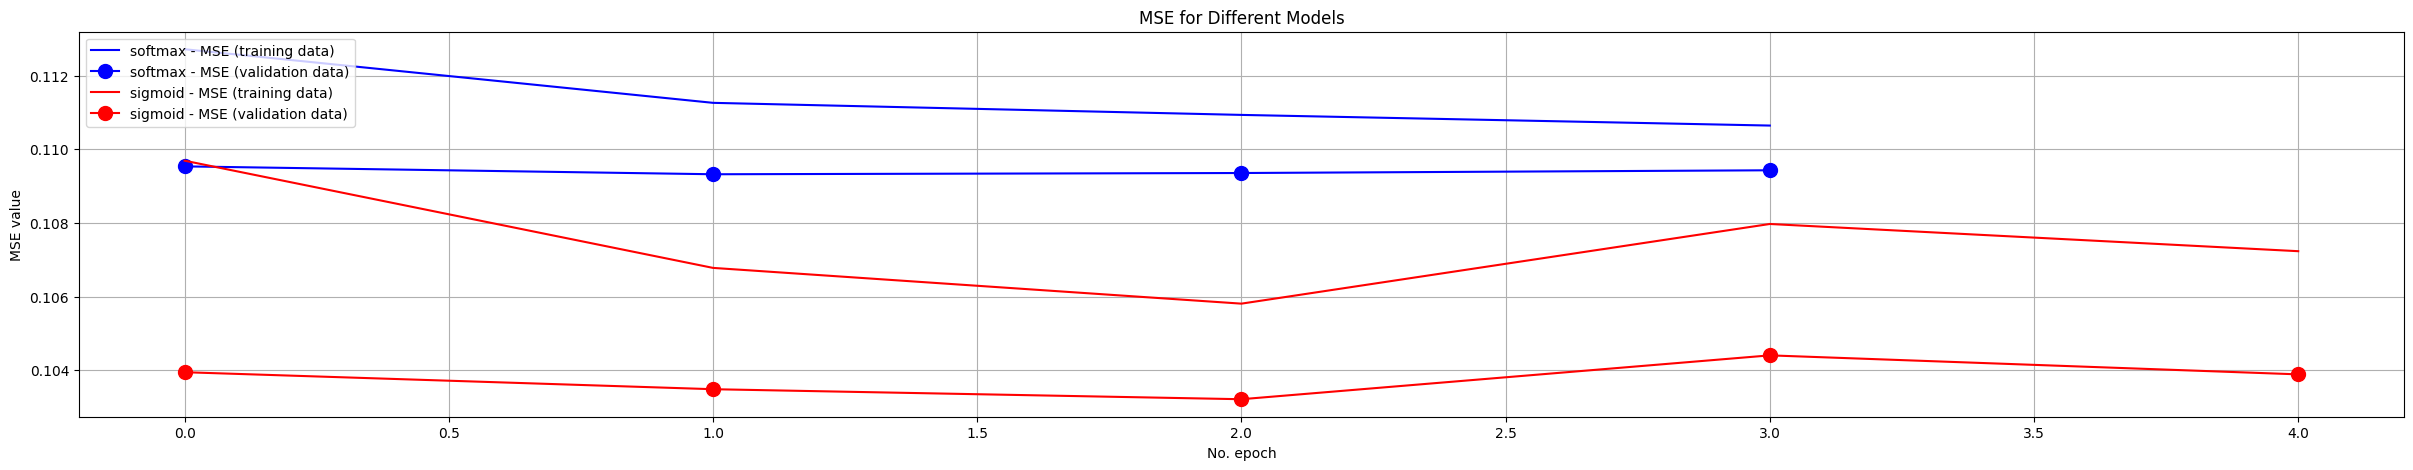

In [152]:
plt.rcdefaults()
plt.figure(figsize=(30,5))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['loss'], label=f'{model_name} - MSE (training data)', color=color_plot)
    plt.plot(history.history['val_loss'], label=f'{model_name} - MSE (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('MSE for Different Models')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

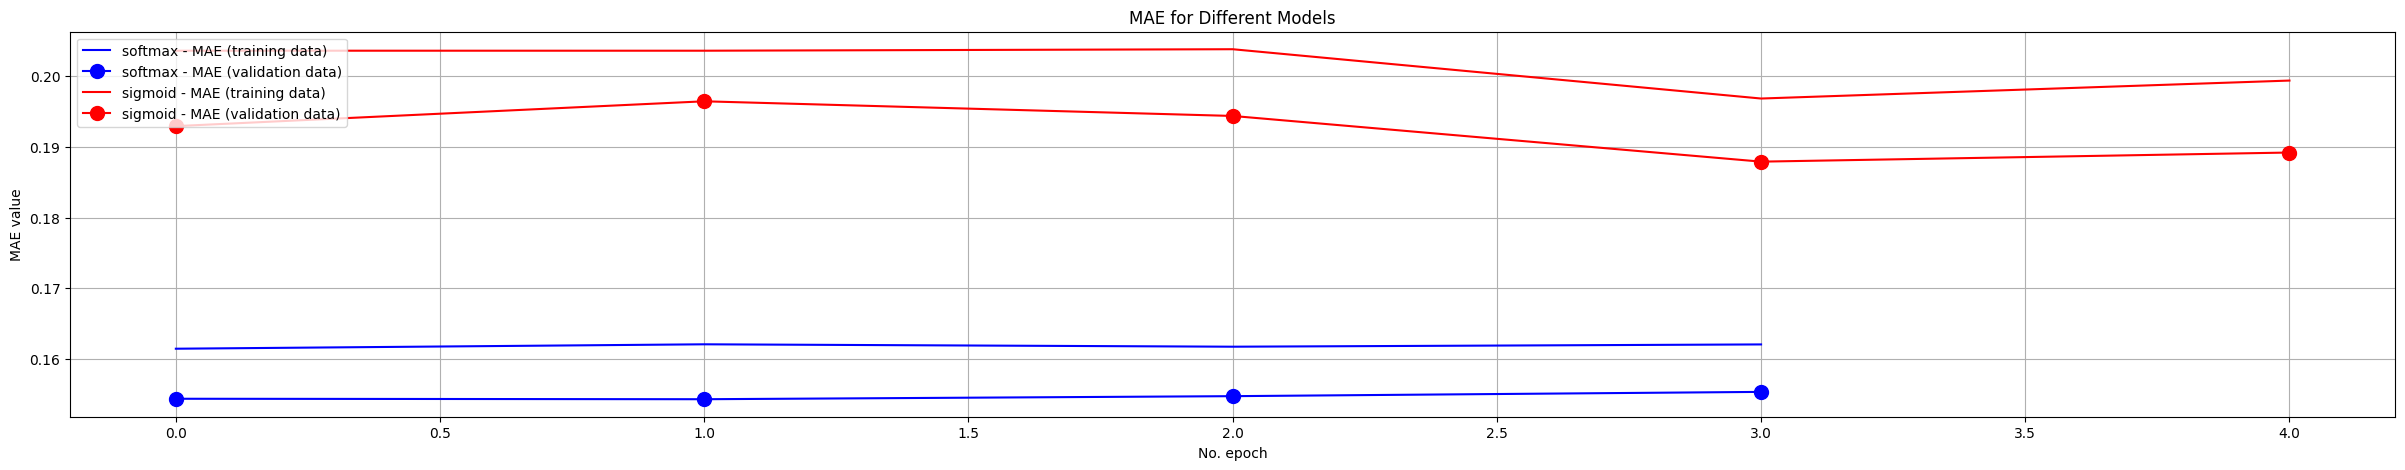

In [153]:
plt.rcdefaults()
plt.figure(figsize=(30,5))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['mean_absolute_error'], label=f'{model_name} - MAE (training data)', color=color_plot)
    plt.plot(history.history['val_mean_absolute_error'], label=f'{model_name} - MAE (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('MAE for Different Models')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [154]:
# lstm_model.evaluate(
#     x=features_tensor,
#     y=targets_tensor
# )

## Making Predictions

In [155]:
len(model_features_validation)

5164

In [156]:
features_tensor_validation =  tf.convert_to_tensor(
    np.array(
        [tf.convert_to_tensor(data) for data in model_features_validation]
    )
)


In [157]:
features_tensor_validation

<tf.Tensor: shape=(5164, 60, 5), dtype=float64, numpy=
array([[[-0.17668437,  0.26157424, -3.90806696, -1.69594097,
         -0.26631315],
        [-0.13461048, -1.53324529, -4.33609246, -2.03883147,
         -0.1809628 ],
        [-1.03804003, -0.60948473, -4.25463565, -1.40660489,
          0.2270625 ],
        ...,
        [ 3.56466183, -1.48914055,  1.21528258, -1.80157924,
         -0.10913954],
        [-0.34353336, -0.61529213,  1.47463895, -1.05745363,
          0.84617547],
        [ 0.14127003,  0.48309603,  1.20525877, -1.2757473 ,
          0.4240592 ]],

       [[-0.13461048, -1.53324529, -4.33609246, -2.03883147,
         -0.1809628 ],
        [-1.03804003, -0.60948473, -4.25463565, -1.40660489,
          0.2270625 ],
        [-2.34741852,  0.26885018, -0.27853832, -3.13741326,
         -0.41760061],
        ...,
        [-0.34353336, -0.61529213,  1.47463895, -1.05745363,
          0.84617547],
        [ 0.14127003,  0.48309603,  1.20525877, -1.2757473 ,
          0.4240

In [158]:
for model_name in models_to_test:
    models_to_test[model_name]["predictions"] = models_to_test[model_name]["model"].predict( x = features_tensor_validation )

In [159]:
models_to_test

{'softmax': {'last_activation_layer': 'softmax',
  'callbacks': [<tensorflow.python.keras.callbacks.EarlyStopping at 0x22ecd374a90>,
  'history': <tensorflow.python.keras.callbacks.History at 0x22f27f7b970>,
  'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x22ecd3a17f0>,
  'color_plot': 'blue',
  'predictions': array([[0.40297616, 0.05571849, 0.01088006, ..., 0.0186911 , 0.41380325,
          0.01666287],
         [0.40295815, 0.05571394, 0.01087955, ..., 0.01869353, 0.41381618,
          0.01666432],
         [0.40295953, 0.05571724, 0.01088114, ..., 0.01869367, 0.41380408,
          0.01666583],
         ...,
         [0.40298834, 0.05571831, 0.01087945, ..., 0.01868961, 0.41380402,
          0.01665982],
         [0.40295178, 0.05572102, 0.01088279, ..., 0.01869618, 0.41378742,
          0.01667073],
         [0.40297934, 0.05572162, 0.01088157, ..., 0.0186922 , 0.41378936,
          0.01666394]], dtype=float32)},
 'sigmoid': {'last_activation_layer': 'sigmoid',


In [160]:
sigmoid_predictions = models_to_test["sigmoid"]["predictions"]
softmax_predictions = models_to_test["softmax"]["predictions"]

In [178]:
# sigmoid_predictions
softmax_predictions

array([[0.40297616, 0.05571849, 0.01088006, ..., 0.0186911 , 0.41380325,
        0.01666287],
       [0.40295815, 0.05571394, 0.01087955, ..., 0.01869353, 0.41381618,
        0.01666432],
       [0.40295953, 0.05571724, 0.01088114, ..., 0.01869367, 0.41380408,
        0.01666583],
       ...,
       [0.40298834, 0.05571831, 0.01087945, ..., 0.01868961, 0.41380402,
        0.01665982],
       [0.40295178, 0.05572102, 0.01088279, ..., 0.01869618, 0.41378742,
        0.01667073],
       [0.40297934, 0.05572162, 0.01088157, ..., 0.0186922 , 0.41378936,
        0.01666394]], dtype=float32)

In [179]:
# sigmoid_predictions[0]
softmax_predictions[0]

array([4.0297616e-01, 5.5718493e-02, 1.0880064e-02, 8.7765208e-04,
       1.8496929e-02, 4.5693763e-05, 3.1491090e-05, 8.0704565e-05,
       8.1478182e-04, 6.0761258e-02, 1.5947960e-04, 1.8691104e-02,
       4.1380325e-01, 1.6662870e-02], dtype=float32)

In [180]:
# sigmoid_predictions[1]
softmax_predictions[1]

array([4.02958155e-01, 5.57139404e-02, 1.08795455e-02, 8.77683226e-04,
       1.84976608e-02, 4.56867383e-05, 3.14872668e-05, 8.06938478e-05,
       8.14684550e-04, 6.07669093e-02, 1.59463219e-04, 1.86935328e-02,
       4.13816184e-01, 1.66643187e-02], dtype=float32)

In [163]:
def test_predictions(predictions_test, num_labels):
    label_index_teste = np.argmax(predictions_test[0][:num_labels])
    state_index_teste = np.argmax(predictions_test[0][num_labels:])

    for array in predictions_test:
        if (label_index_teste != np.argmax(array[:num_labels])) and (state_index_teste != np.argmax(array[num_labels:])):
            print("Exist at least one different prediction")
            return
    print("Does not exist different predictions")


In [164]:
test_predictions(softmax_predictions, num_labels)

Does not exist different predictions


In [165]:
test_predictions(sigmoid_predictions, num_labels)

Does not exist different predictions


In [166]:
def transform_prediction(prediction_np, num_states, num_labels):
    zeros_base_array = np.zeros(num_labels + num_states)

    label_index = np.argmax(prediction_np[:num_labels])
    state_index = np.argmax(prediction_np[num_labels:])

    zeros_base_array[label_index] = 1
    zeros_base_array[num_labels + state_index] = 1

    return zeros_base_array

In [167]:
transformed_array_list = []


for prediction in sigmoid_predictions:
    binary_array = transform_prediction(prediction, num_states, num_labels).reshape(1, num_states + num_labels)
    transformed_array_list.append(binary_array)


In [168]:
fittable_econder_array = np.concatenate(transformed_array_list, axis=0)

In [169]:
unique_values = np.unique(fittable_econder_array, axis=0)

unique_values

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [170]:
enc.inverse_transform(fittable_econder_array)

array([[0, 'Not Defined/Transient'],
       [0, 'Not Defined/Transient'],
       [0, 'Not Defined/Transient'],
       ...,
       [0, 'Not Defined/Transient'],
       [0, 'Not Defined/Transient'],
       [0, 'Not Defined/Transient']], dtype=object)

In [171]:
enc.get_feature_names()

array(['x0_0', 'x0_1', 'x0_2', 'x0_3', 'x0_4', 'x0_5', 'x0_6', 'x0_7',
       'x1_Amusement', 'x1_Baseline', 'x1_Error/Not Labeled',
       'x1_Meditation', 'x1_Not Defined/Transient', 'x1_Stress'],
      dtype=object)

In [172]:
target_validation_array_list = []

for array in model_targets_validation:
    target_validation_array_list.append(array.reshape(1,14))

target_validation_array = np.concatenate(target_validation_array_list, axis=0)

In [181]:
target_validation_array

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [182]:
target_validation_array[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [183]:
target_validation_array[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [173]:
unique_values1 = np.unique(target_validation_array, axis=0)

unique_values1

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [174]:
np.concatenate(target_validation_array_list, axis=0)

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [175]:
labeled_validation = enc.inverse_transform(model_targets_validation.tolist())

In [176]:
labeled_validation

array([[0, 'Not Defined/Transient'],
       [0, 'Not Defined/Transient'],
       [0, 'Not Defined/Transient'],
       ...,
       [0, 'Not Defined/Transient'],
       [0, 'Not Defined/Transient'],
       [0, 'Not Defined/Transient']], dtype=object)